In [44]:
# custom analysis tools
from analysis.scan import scan
from analysis.tools import extract_species
from analysis.tools import muon_filter
from analysis.tools import muon_filter_by_parts

# useful python libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.optimize import curve_fit
import pandas as pd
from prettytable import PrettyTable

plt.rcParams['figure.figsize'] = 26, 10
plt.style.use('ggplot')

left = 1; right = 799

STUDY = 'master_neutrons'

# Get the current directory where the Jupyter Notebook is located

current_directory = get_ipython().run_line_magic('pwd', '')

# Extract the local path to 3CS folder
local_path        = current_directory.split('repo_note3cs')[0]

# Define path to study within data3cs folder
path_to_study     = f'repo_data3cs/data3cs/studies/{STUDY}'

# Final path
path              = f'{local_path}{path_to_study}'

# Irradiation group
LiF_irrad                = extract_species(path, 'LiF', ext='irrad') 
LiF_irrad_samples = [ 'LiF_B2_145', 'LiF_B2_157', 'LiF_B2_158']

BaF_irrad                = extract_species(path, 'BaF', ext='irrad') 
BaF_irrad_samples = ['BaF_B2_181','BaF_B2_183', 'BaF_B2_185', 'BaF_B2_192']

Qz_irrad                   = extract_species(path, 'Qz', ext='irrad') 
Qz_irrad_samples    = ['Qz_B2_063', 'Qz_B2_069', 'Qz_B2_072']

SP_irrad                   = extract_species(path, 'SP', ext='irrad') 
SP_irrad_samples     = ['SP4500', 'SP4501', 'SP4502', 'SP4503']

# Control group
LiF_ctrl                     = extract_species(path, 'LiF', ext='ctrl') 
LiF_ctrl_samples      = ['LiF_B2_143', 'LiF_B2_155']

BaF_ctrl                     = extract_species(path, 'BaF', ext='ctrl') 
BaF_ctrl_samples     = ['BaF_B2_182','BaF_B2_188', 'BaF_B2_193']

Qz_ctrl                        = extract_species(path, 'Qz', ext='ctrl') 
Qz_ctrl_samples         = ['Qz_B2_064',  'Qz_B2_071']

SP_ctrl                        = extract_species(path, 'SP', ext='ctrl') 
SP_ctrl_samples         = ['SP4504']

In [11]:
def cut_array(input, cuts = 1):
    left = cuts
    right = len(input) - 1
    return input[left:right]

def add_spectra(group, samples, wl, centre, type, colls):
    spectra_array = []
    count                = 0

    if type == 'bg':
        its = 1
    elif type == 'sp':
        its = 4

    for coll in colls:
        for sample in samples:
            df = group[f'coll{coll}'][f'{sample}_{centre}'].df
            for it in range(its):
                y   = np.array(df.loc[(wl, '0', '15.0sec', f'{type}_{it}')]['count'])
                y   = cut_array(y)
                y_filtered = muon_filter_by_parts(y)
                spectra_array.append(y_filtered)
                count+=1

    x = np.array(df.loc[(wl, '0', '15.0sec', f'{type}_{it}')]['em_wl'])
    x = cut_array(x)

    arrays_np = np.array(spectra_array)
    nanmean = np.nanmean(arrays_np, axis=0)
    
    return x, nanmean, count

def Gaussian(x, A, m, s, offset = 0):
    return A * np.exp( -0.5 * ((x - m)**2) / (s**2) ) + offset

def offset_4Gaussians(x, A1, A2, A3, A4, m1, m2, m3, m4, s1, s2, s3, s4, offset):
    a = Gaussian(x, A1, m1, s1)
    b = Gaussian(x, A2, m2, s2)
    c = Gaussian(x, A3, m3, s3)
    d = Gaussian(x, A4, m4, s4)

    return a+b+c+d+offset

def offset_5Gaussians(x, A1, A2, A3, A4, A5, m1, m2, m3, m4, m5, s1, s2, s3, s4, s5, offset):
    a = Gaussian(x, A1, m1, s1)
    b = Gaussian(x, A2, m2, s2)
    c = Gaussian(x, A3, m3, s3)
    d = Gaussian(x, A4, m4, s4)
    e = Gaussian(x, A5, m5, s5)

    return a+b+c+d+e+offset

In [56]:
#bg models

# bkgs offset manually set to 315
#original values:
# 250 :  314.181
# 320 : 314.845
# 435 : 315.536

bkg_250 = [  4.11988944 ,  5.757796 ,   19.6223119,   -9.69799666 , 10.5641773,
 439.936038 ,  495.69336435 ,546.57268588 ,601.7559566 , 605.42206786,
   5.89833756  , 7.48714367   ,5.44249217,  -5.82091785 , 12.98600865,
 315 ]

bkg_320 = [459.59349593, 967.84928263   ,4.98752523 ,315]

bkg_435 = [  8.76609133  ,10.46031313  ,50.51038021, -48.75345784 , 51.51011464,
 455.02892594, 491.74321717 ,546.72075592 ,601.35695421, 603.33838787,
   8.68728288 , 14.79082917  , 5.90917478  ,7.66695692 , 11.52427167,
 315]

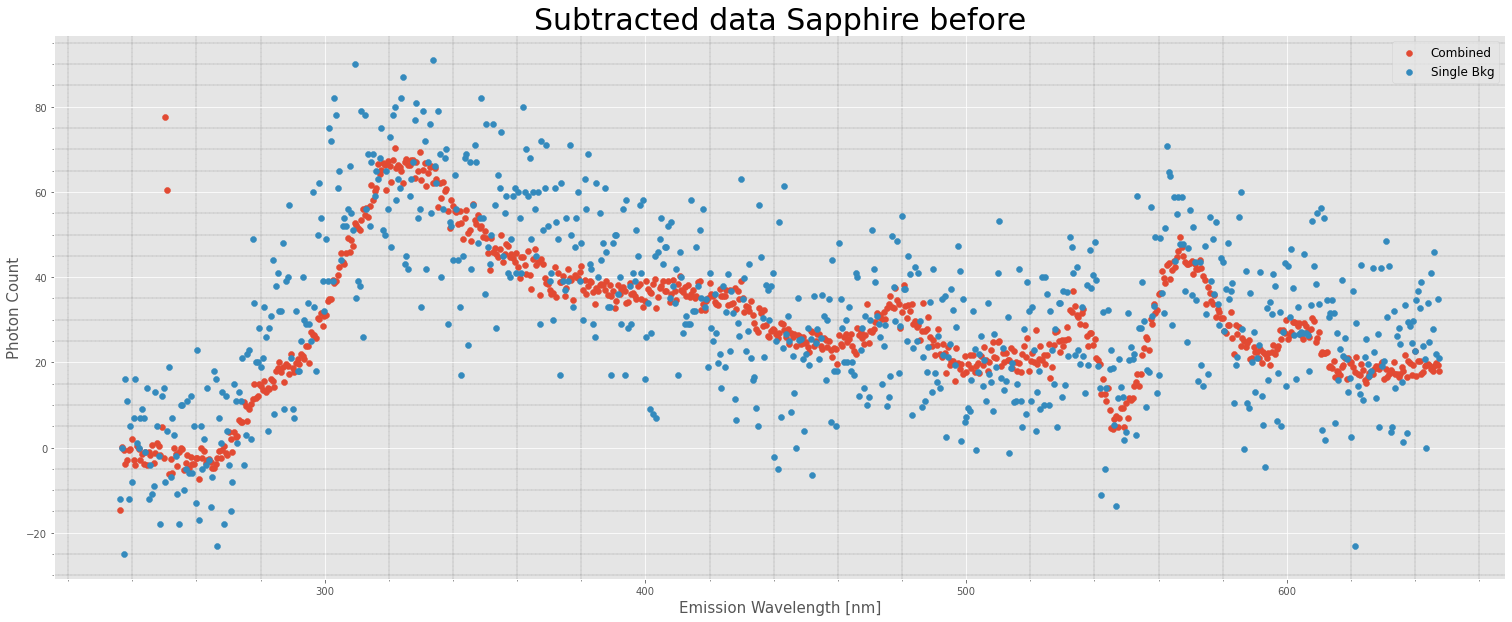

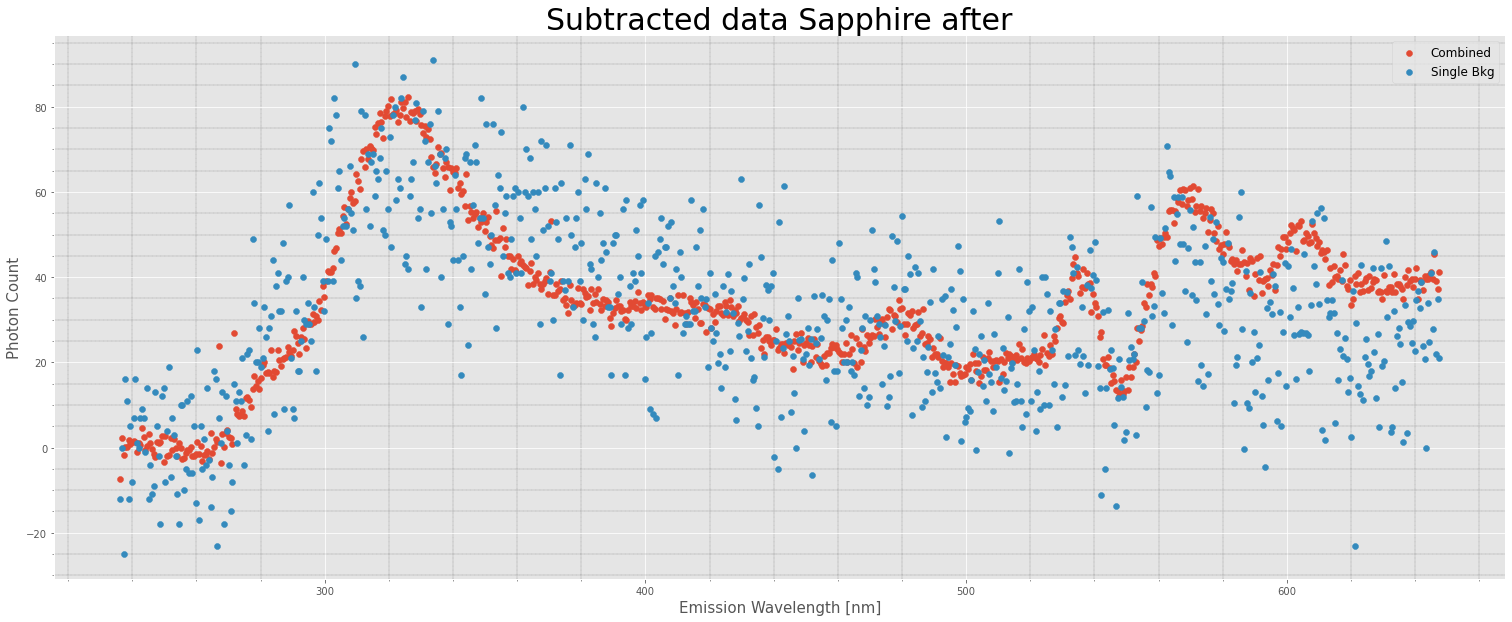

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


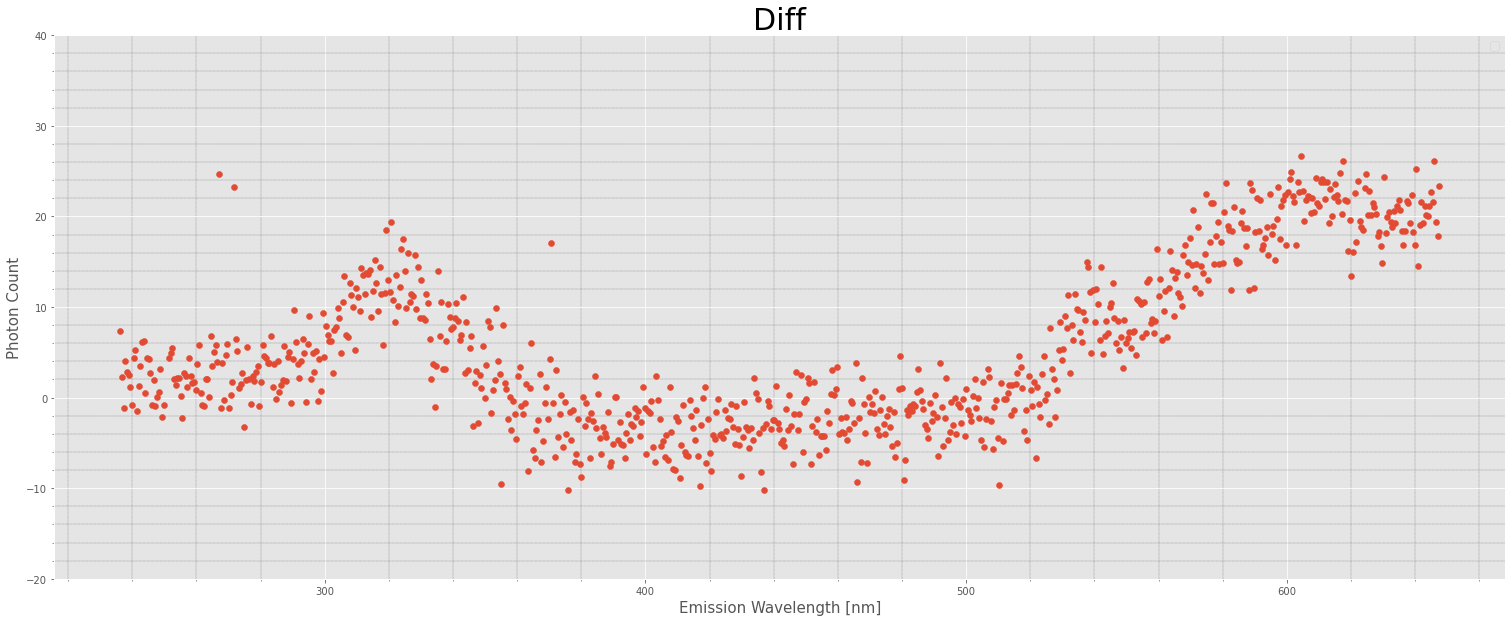

In [57]:
x, Y, c_sp_irrad = add_spectra(SP_irrad, SP_irrad_samples, '250', 'A', 'sp',  ['1', '2', '3'])

nan_index =[]

size = len(x)
for i in range(0,size):
    if np.isnan(Y[i]):
        print(Y[i])
        nan_index.append(i)

Y_free = np.delete(Y, nan_index)
x_free = np.delete(x, nan_index)

#bg model
Y_bkg                 = offset_5Gaussians(x_free, *bkg_250)

Y_sub = np.subtract(Y_free, Y_bkg)

plt.scatter(x_free,Y_sub, label = 'Combined')

df = SP_irrad['coll3']['SP4502_A'].df
y   = np.array(df.loc[('250', '0', '15.0sec', 'sp_0')]['count'])[left:right]
y_sub = np.subtract(y, Y_bkg)

plt.scatter(x,y_sub, label = 'Single Bkg')

plt.legend(fontsize = 12)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Subtracted data Sapphire before', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
plt.show();

Y_before = np.copy(Y_sub)


x, Y, c_sp_irrad = add_spectra(SP_irrad, SP_irrad_samples, '250', 'A', 'sp',  ['4', '5', '6'])

nan_index =[]

size = len(x)
for i in range(0,size):
    if np.isnan(Y[i]):
        print(Y[i])
        nan_index.append(i)

Y_free = np.delete(Y, nan_index)
x_free = np.delete(x, nan_index)

#bg model
Y_bkg                 = offset_5Gaussians(x_free, *bkg_250)

Y_sub = np.subtract(Y_free, Y_bkg)

plt.scatter(x_free,Y_sub, label = 'Combined')

df = SP_irrad['coll3']['SP4502_A'].df
y   = np.array(df.loc[('250', '0', '15.0sec', 'sp_0')]['count'])[left:right]
y_sub = np.subtract(y, Y_bkg)

plt.scatter(x,y_sub, label = 'Single Bkg')

plt.legend(fontsize = 12)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Subtracted data Sapphire after', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
plt.show();

Y_after = np.copy(Y_sub)

Y_diff = np.subtract(Y_after, Y_before)
plt.scatter(x_free, Y_diff)
plt.legend(fontsize = 12)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Diff', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
plt.ylim(-20,40)
plt.show();

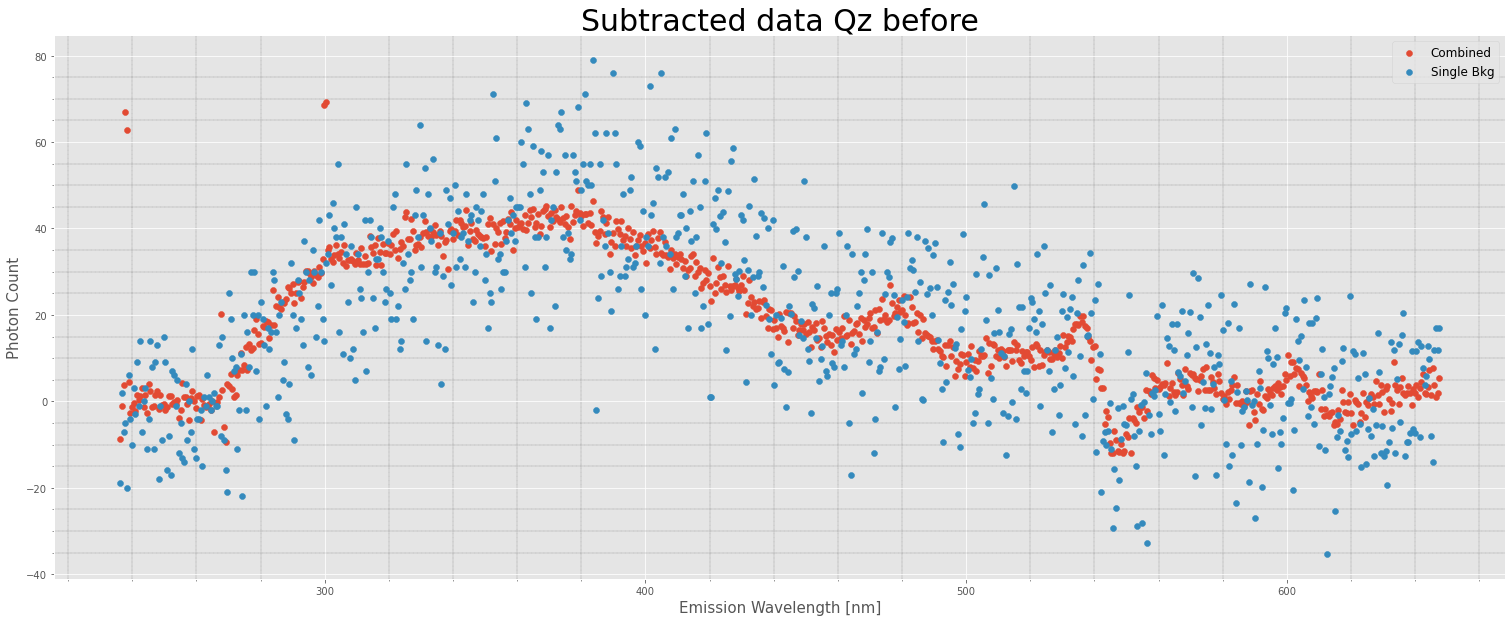

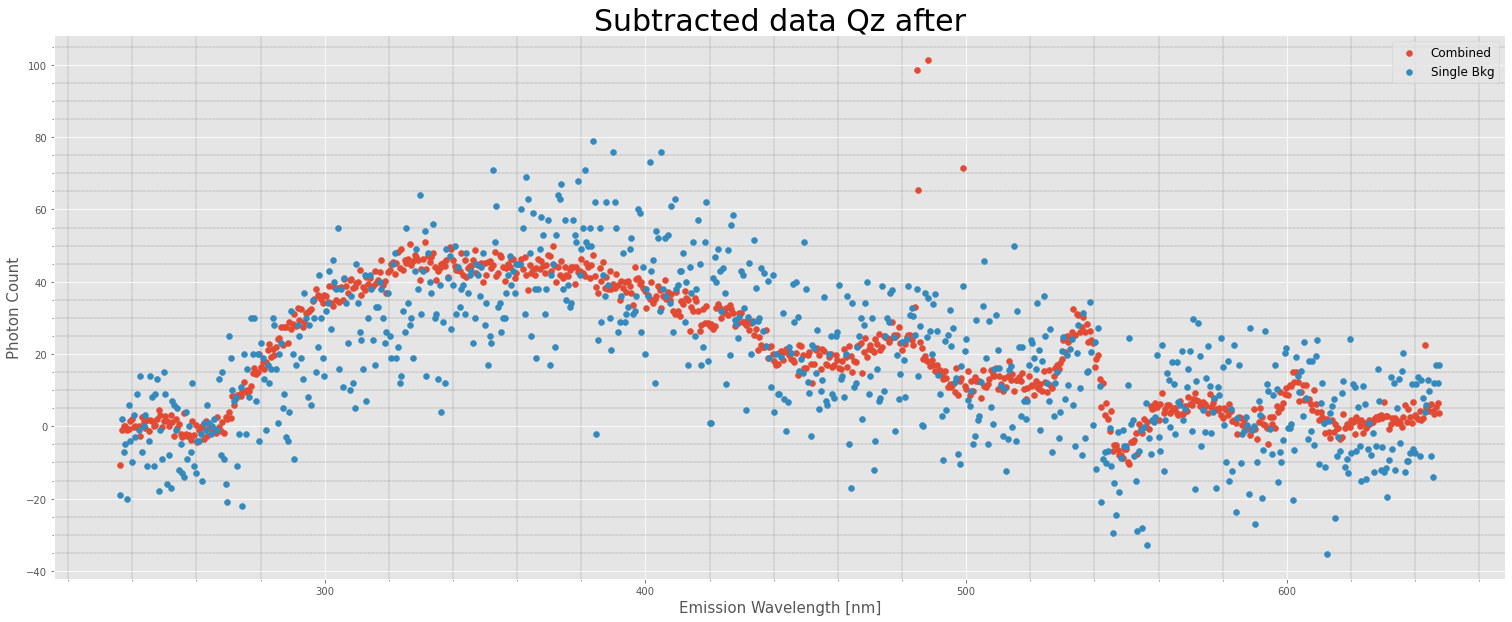

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


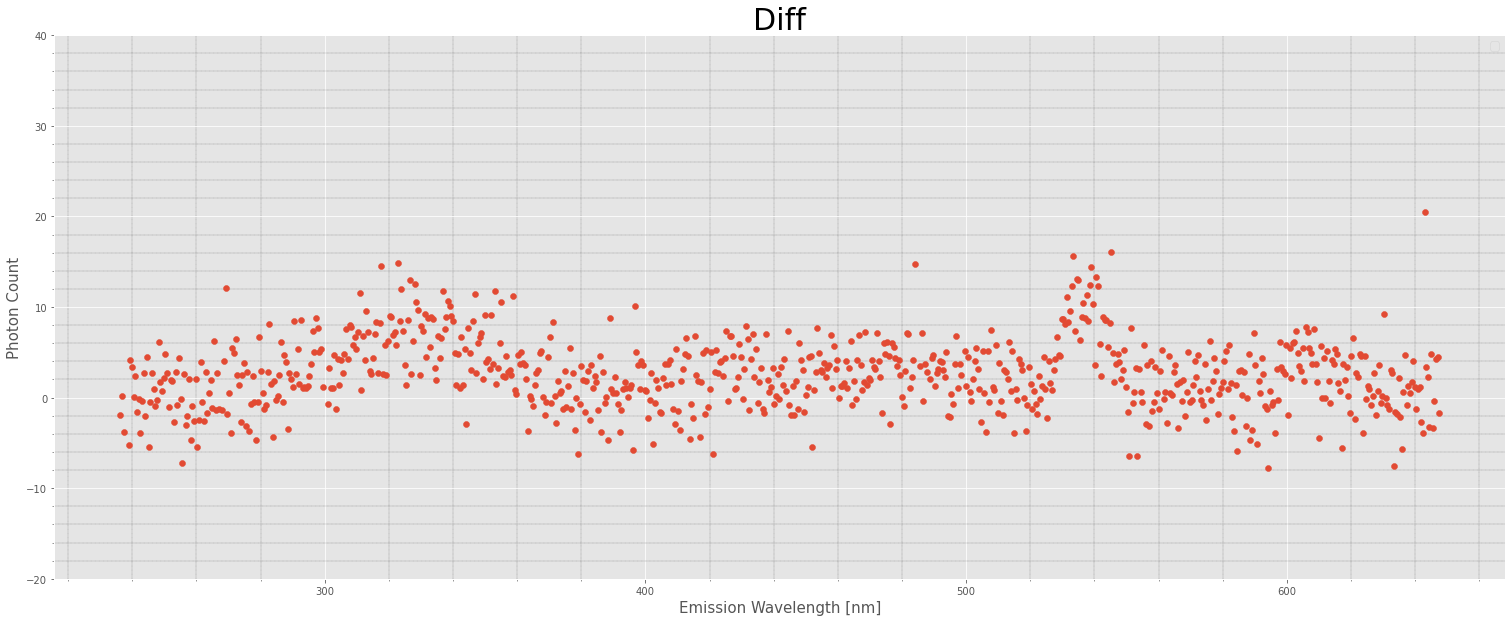

In [58]:
x, Y, c_sp_irrad = add_spectra(Qz_irrad, Qz_irrad_samples, '250', 'A', 'sp',  ['1', '2', '3'])

nan_index =[]

size = len(x)
for i in range(0,size):
    if np.isnan(Y[i]):
        print(Y[i])
        nan_index.append(i)

Y_free = np.delete(Y, nan_index)
x_free = np.delete(x, nan_index)

#bg model
Y_bkg                 = offset_5Gaussians(x_free, *bkg_250)

Y_sub = np.subtract(Y_free, Y_bkg)

plt.scatter(x_free,Y_sub, label = 'Combined')

df = Qz_irrad['coll3']['Qz_B2_063_A'].df
y   = np.array(df.loc[('250', '0', '15.0sec', 'sp_0')]['count'])[left:right]
y_sub = np.subtract(y, Y_bkg)

plt.scatter(x,y_sub, label = 'Single Bkg')

plt.legend(fontsize = 12)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Subtracted data Qz before', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
plt.show();

Y_before = np.copy(Y_sub)


x, Y, c_sp_irrad = add_spectra(Qz_irrad, Qz_irrad_samples, '250', 'A', 'sp',  ['4', '5', '6'])

nan_index =[]

size = len(x)
for i in range(0,size):
    if np.isnan(Y[i]):
        print(Y[i])
        nan_index.append(i)

Y_free = np.delete(Y, nan_index)
x_free = np.delete(x, nan_index)

#bg model
Y_bkg                 = offset_5Gaussians(x_free, *bkg_250)

Y_sub = np.subtract(Y_free, Y_bkg)

plt.scatter(x_free,Y_sub, label = 'Combined')

df = Qz_irrad['coll3']['Qz_B2_063_A'].df
y   = np.array(df.loc[('250', '0', '15.0sec', 'sp_0')]['count'])[left:right]
y_sub = np.subtract(y, Y_bkg)

plt.scatter(x,y_sub, label = 'Single Bkg')

plt.legend(fontsize = 12)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Subtracted data Qz after', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
plt.show();

Y_after = np.copy(Y_sub)

Y_diff = np.subtract(Y_after, Y_before)
plt.scatter(x_free, Y_diff)
plt.legend(fontsize = 12)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Diff', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
plt.ylim(-20,40)
plt.show();

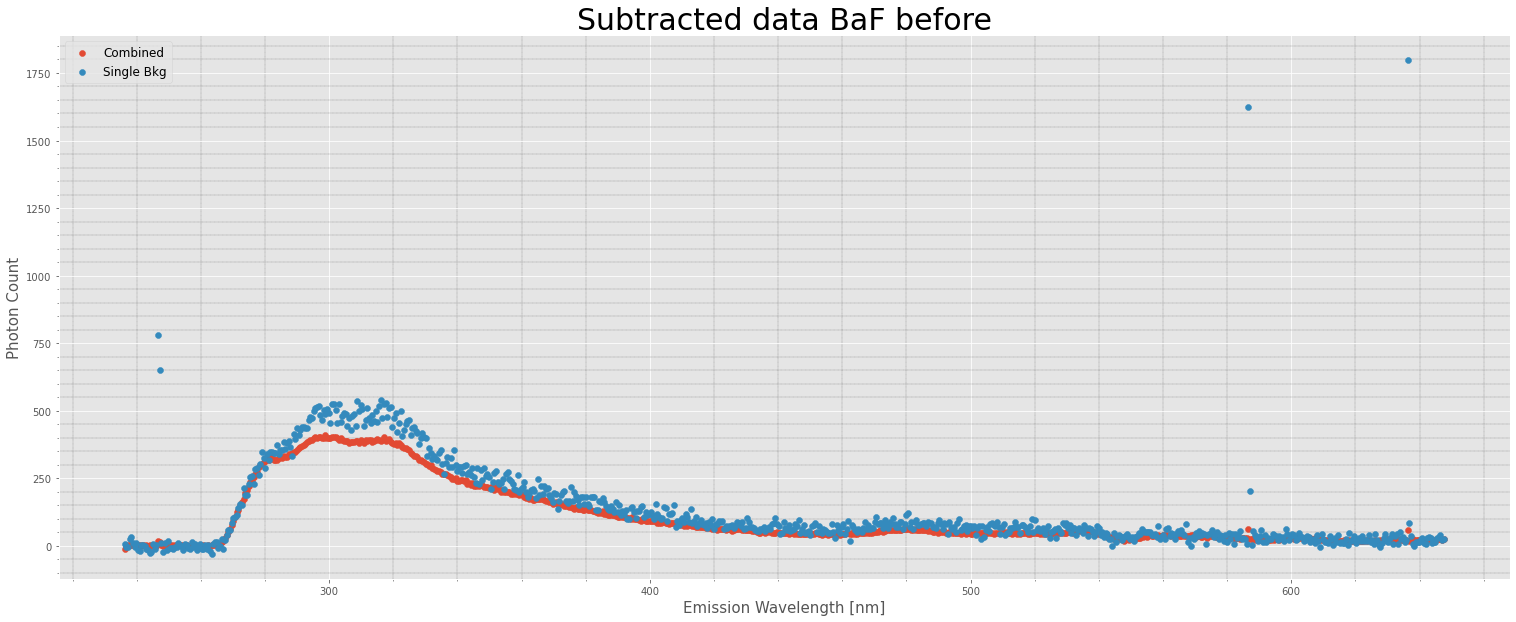

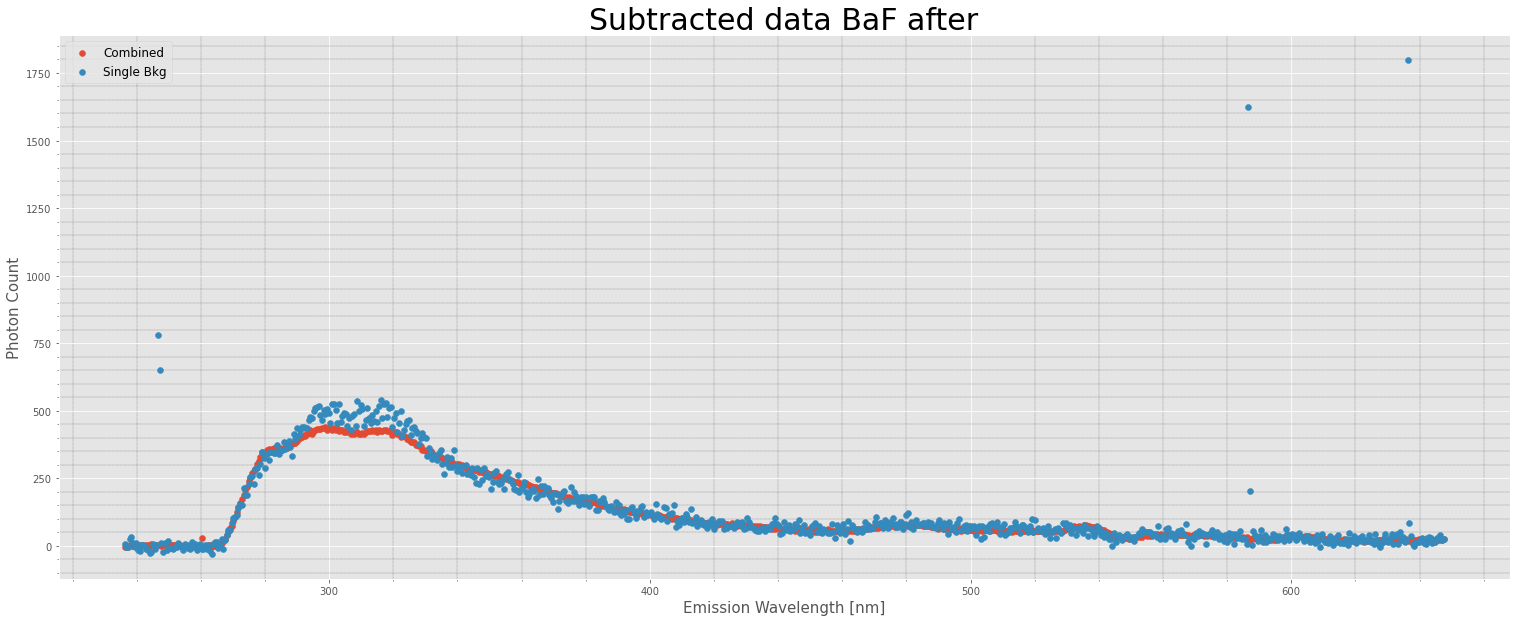

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


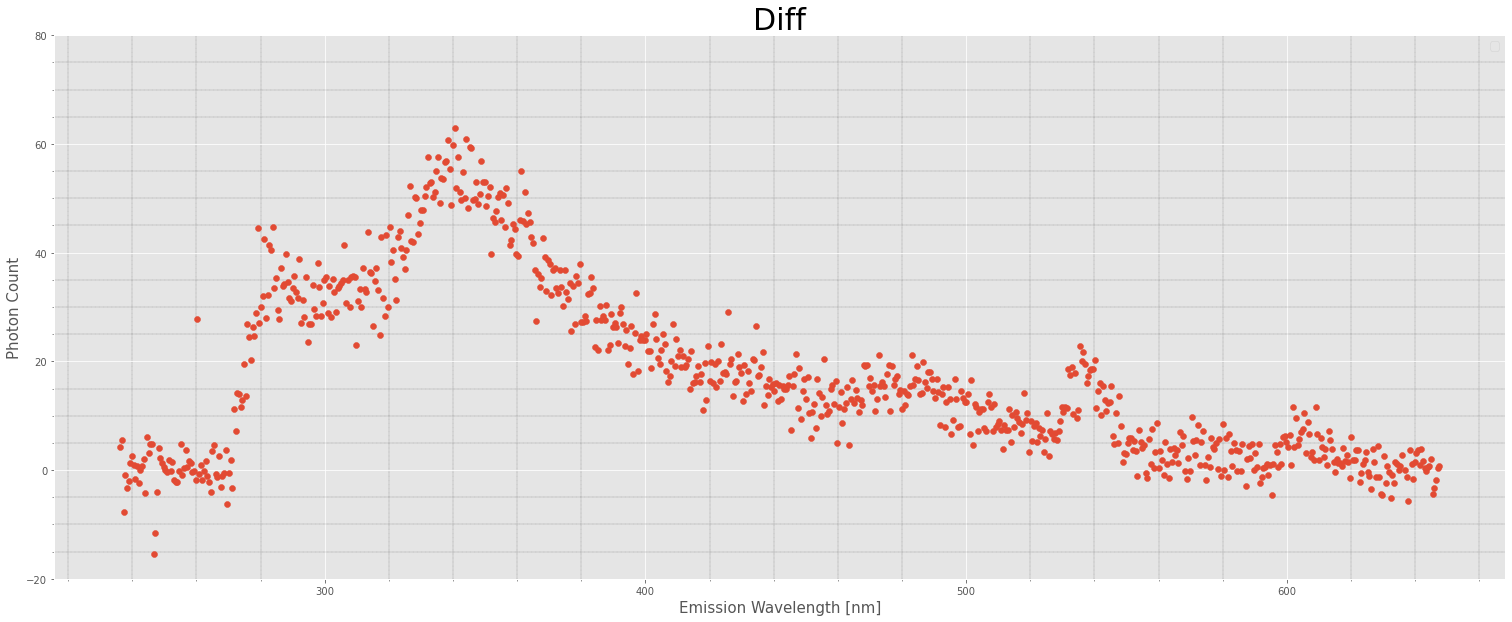

In [59]:
x, Y, c_sp_irrad = add_spectra(BaF_irrad, BaF_irrad_samples, '250', 'A', 'sp',  ['1', '2', '3'])

nan_index =[]

size = len(x)
for i in range(0,size):
    if np.isnan(Y[i]):
        print(Y[i])
        nan_index.append(i)

Y_free = np.delete(Y, nan_index)
x_free = np.delete(x, nan_index)

#bg model
Y_bkg                 = offset_5Gaussians(x_free, *bkg_250)

Y_sub = np.subtract(Y_free, Y_bkg)

plt.scatter(x_free,Y_sub, label = 'Combined')

df = BaF_irrad['coll1']['BaF_B2_181_A'].df
y   = np.array(df.loc[('250', '0', '15.0sec', 'sp_0')]['count'])[left:right]
y_sub = np.subtract(y, Y_bkg)

plt.scatter(x,y_sub, label = 'Single Bkg')

plt.legend(fontsize = 12)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Subtracted data BaF before', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
plt.show();

Y_before = np.copy(Y_sub)


x, Y, c_sp_irrad = add_spectra(BaF_irrad, BaF_irrad_samples, '250', 'A', 'sp',  ['4', '5', '6'])

nan_index =[]

size = len(x)
for i in range(0,size):
    if np.isnan(Y[i]):
        print(Y[i])
        nan_index.append(i)

Y_free = np.delete(Y, nan_index)
x_free = np.delete(x, nan_index)

#bg model
Y_bkg                 = offset_5Gaussians(x_free, *bkg_250)

Y_sub = np.subtract(Y_free, Y_bkg)

plt.scatter(x_free,Y_sub, label = 'Combined')

df = BaF_irrad['coll1']['BaF_B2_181_A'].df
y   = np.array(df.loc[('250', '0', '15.0sec', 'sp_0')]['count'])[left:right]
y_sub = np.subtract(y, Y_bkg)

plt.scatter(x,y_sub, label = 'Single Bkg')

plt.legend(fontsize = 12)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Subtracted data BaF after', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
plt.show();

Y_after = np.copy(Y_sub)

Y_diff = np.subtract(Y_after, Y_before)
plt.scatter(x_free, Y_diff)
plt.legend(fontsize = 12)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Diff', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
plt.ylim(-20,80)
plt.show();

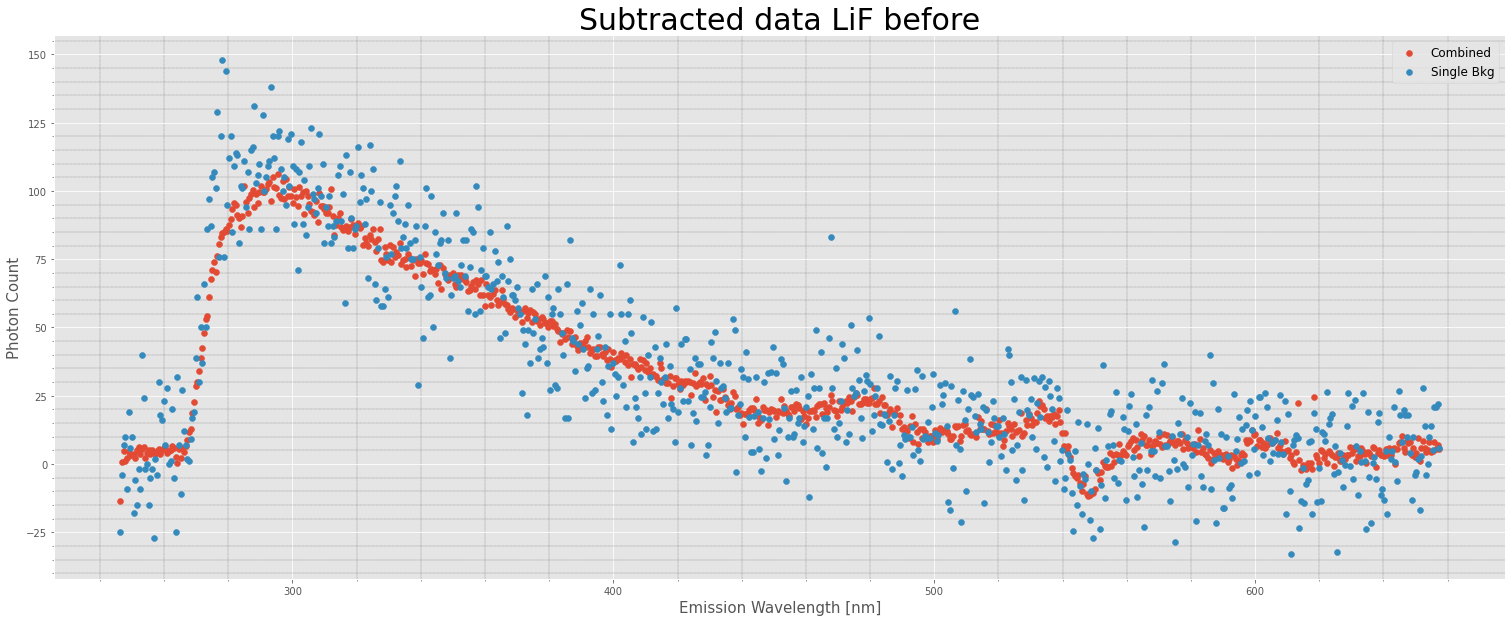

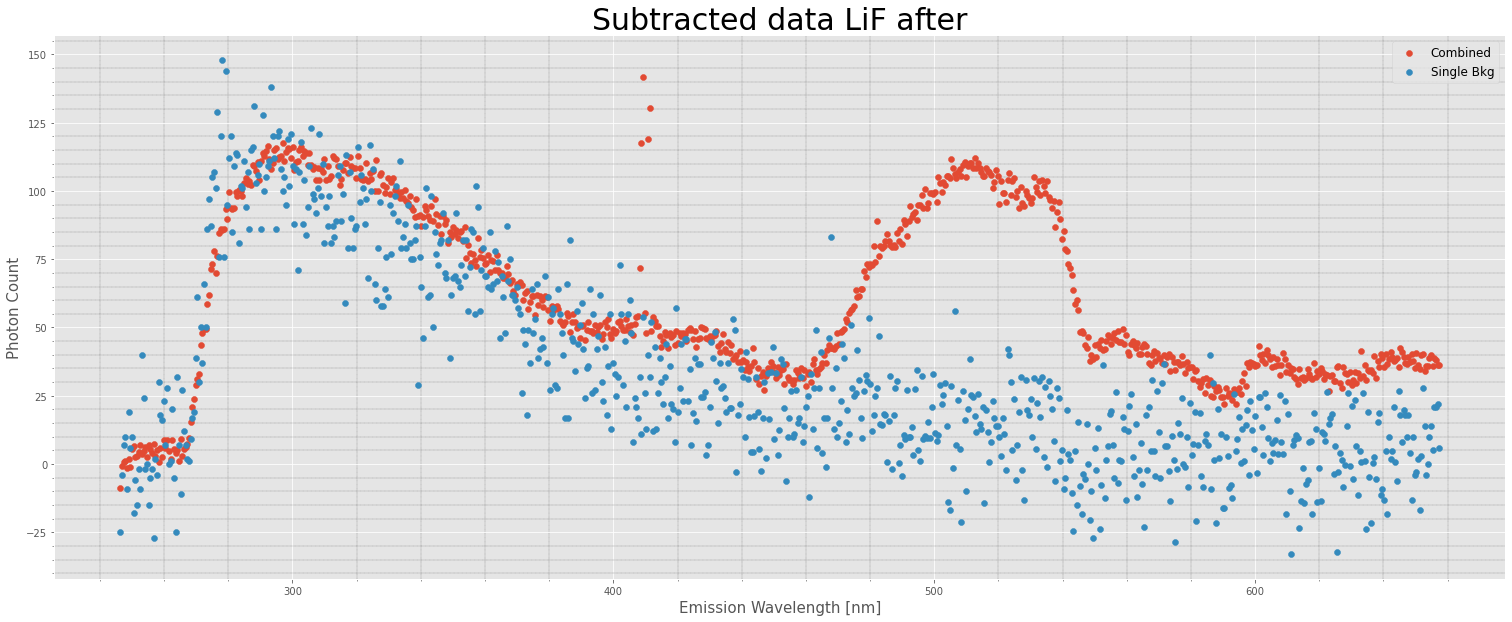

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


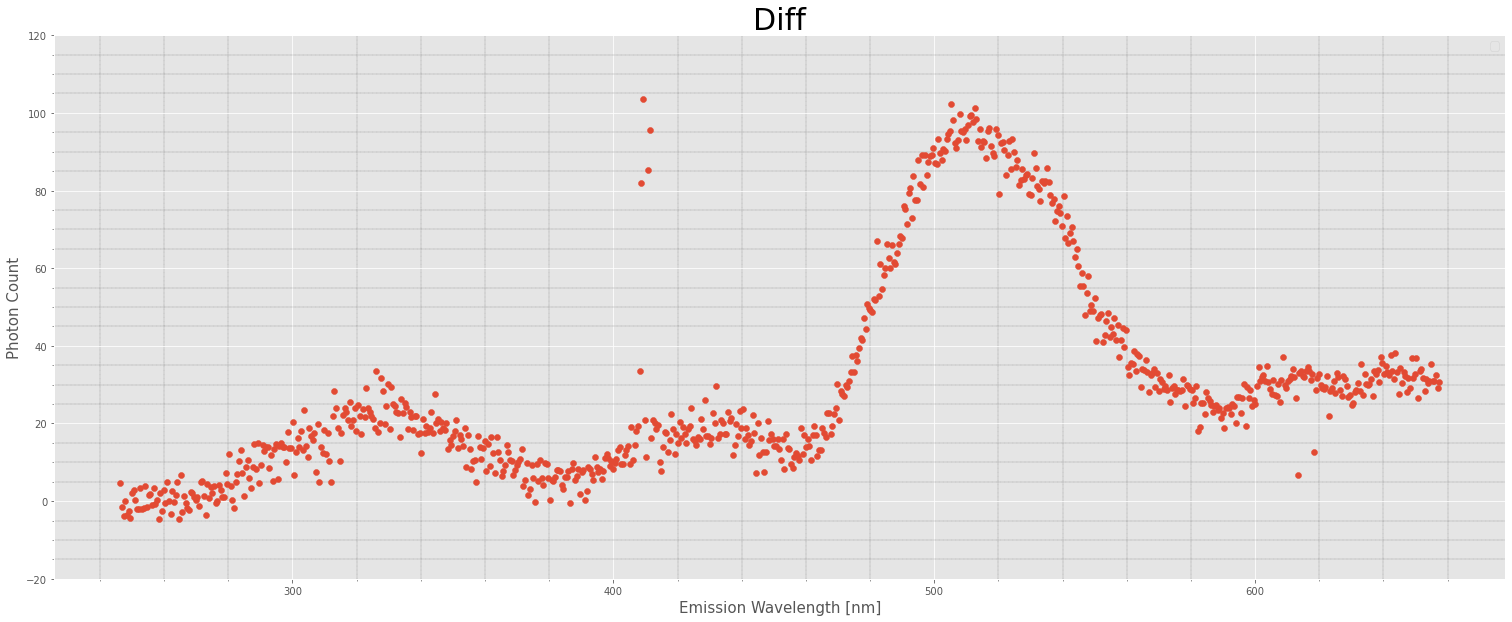

In [60]:
x, Y, c_sp_irrad = add_spectra(LiF_irrad, LiF_irrad_samples, '260', 'A', 'sp',  ['1', '2', '3'])

nan_index =[]

size = len(x)
for i in range(0,size):
    if np.isnan(Y[i]):
        print(Y[i])
        nan_index.append(i)

Y_free = np.delete(Y, nan_index)
x_free = np.delete(x, nan_index)

#bg model
Y_bkg                 = offset_5Gaussians(x_free, *bkg_250)

Y_sub = np.subtract(Y_free, Y_bkg)

plt.scatter(x_free,Y_sub, label = 'Combined')

df = LiF_irrad['coll1']['LiF_B2_157_A'].df
y   = np.array(df.loc[('260', '0', '15.0sec', 'sp_0')]['count'])[left:right]
y_sub = np.subtract(y, Y_bkg)

plt.scatter(x,y_sub, label = 'Single Bkg')

plt.legend(fontsize = 12)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Subtracted data LiF before', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
plt.show();

Y_before = np.copy(Y_sub)


x, Y, c_sp_irrad = add_spectra(LiF_irrad, LiF_irrad_samples, '260', 'A', 'sp',  ['4', '5', '6'])

nan_index =[]

size = len(x)
for i in range(0,size):
    if np.isnan(Y[i]):
        print(Y[i])
        nan_index.append(i)

Y_free = np.delete(Y, nan_index)
x_free = np.delete(x, nan_index)

#bg model
Y_bkg                 = offset_5Gaussians(x_free, *bkg_250)

Y_sub = np.subtract(Y_free, Y_bkg)

plt.scatter(x_free,Y_sub, label = 'Combined')

df = LiF_irrad['coll1']['LiF_B2_157_A'].df
y   = np.array(df.loc[('260', '0', '15.0sec', 'sp_0')]['count'])[left:right]
y_sub = np.subtract(y, Y_bkg)

plt.scatter(x,y_sub, label = 'Single Bkg')

plt.legend(fontsize = 12)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Subtracted data LiF after', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
plt.show();

Y_after = np.copy(Y_sub)

Y_diff = np.subtract(Y_after, Y_before)
plt.scatter(x_free, Y_diff)
plt.legend(fontsize = 12)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Diff', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
plt.ylim(-20,120)
plt.show();

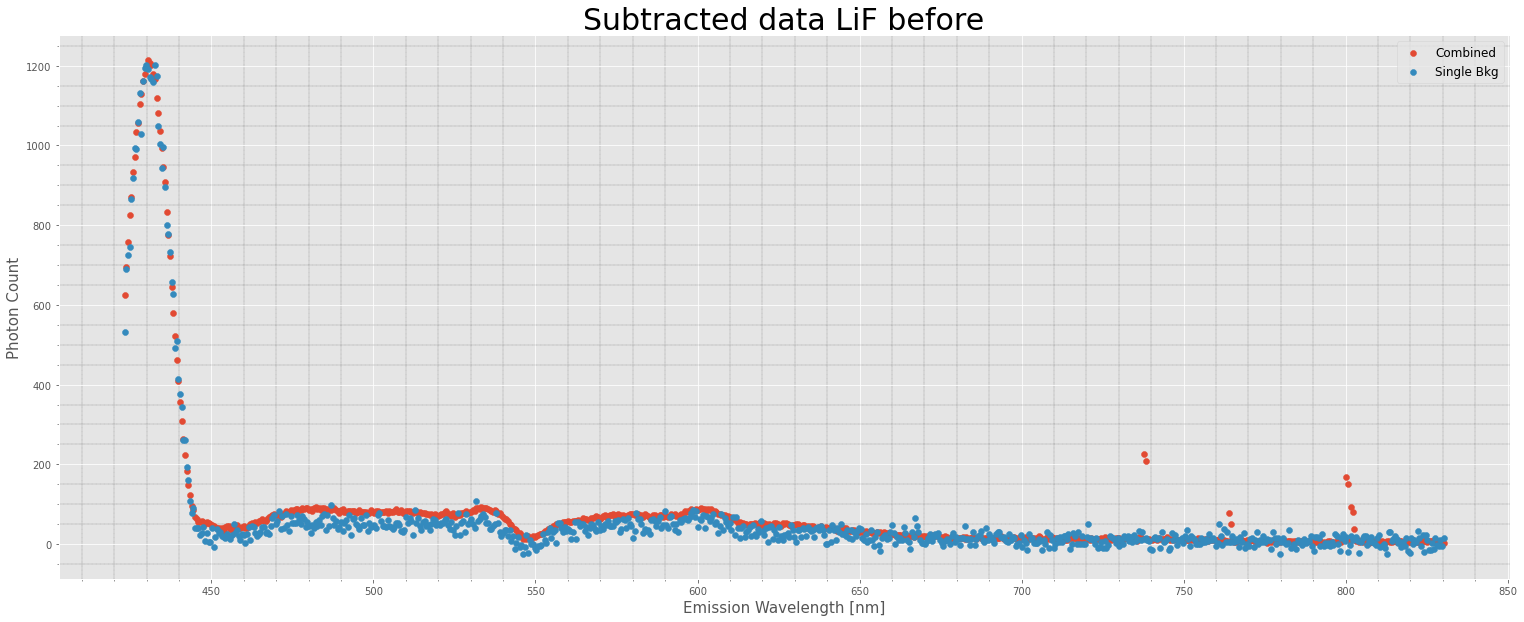

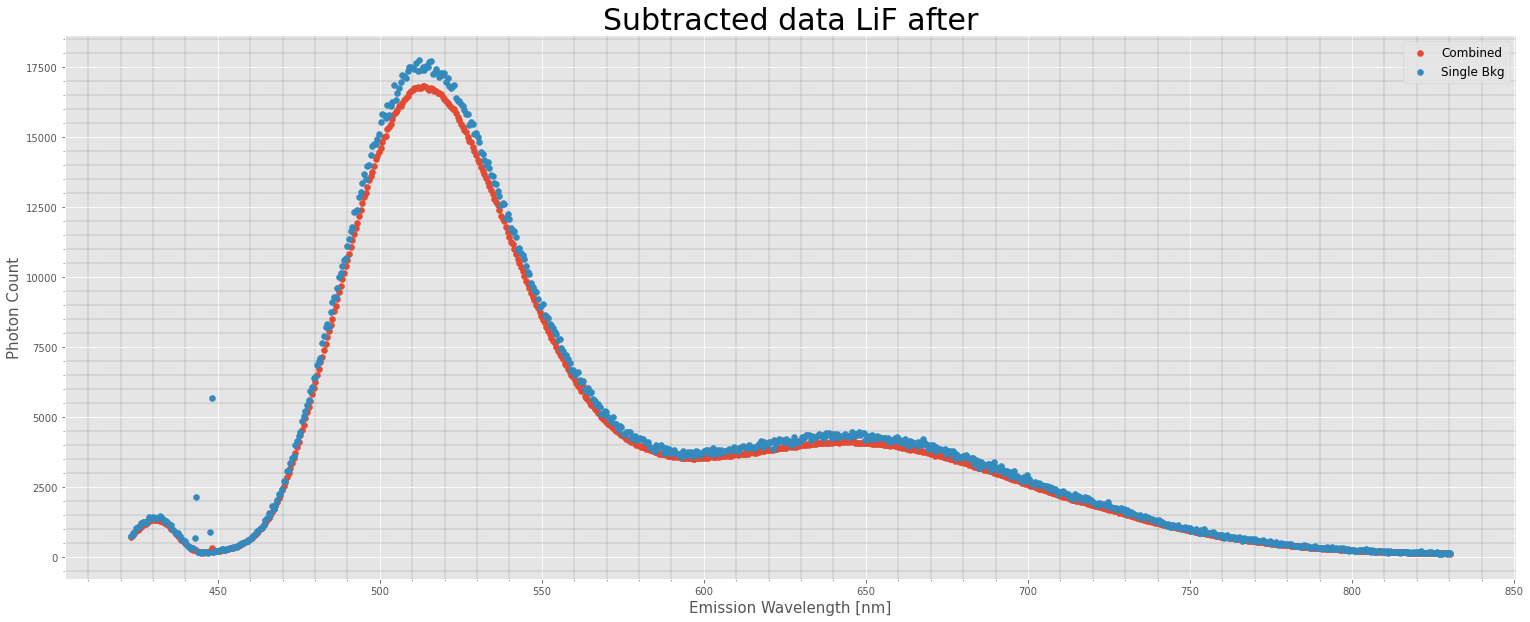

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


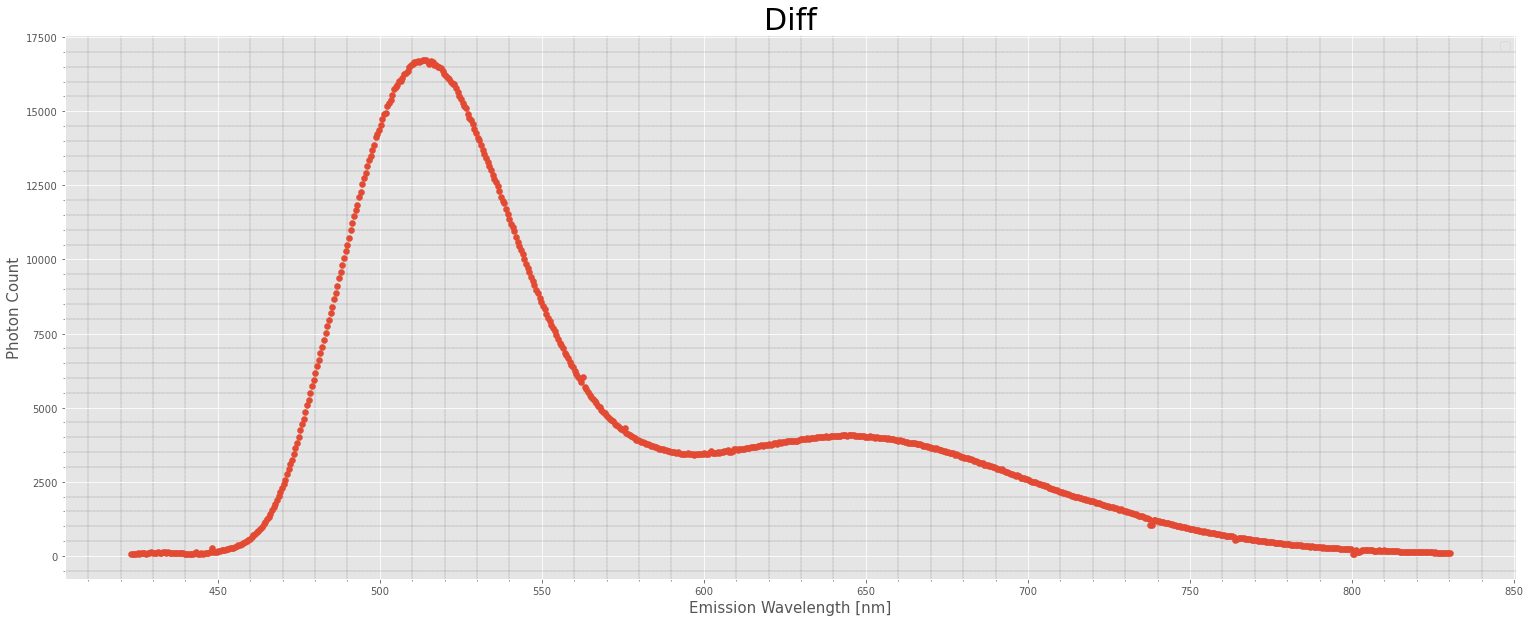

In [61]:
x, Y, c_sp_irrad = add_spectra(LiF_irrad, LiF_irrad_samples, '435', 'B', 'sp',  ['1', '2', '3'])

nan_index =[]

size = len(x)
for i in range(0,size):
    if np.isnan(Y[i]):
        print(Y[i])
        nan_index.append(i)

Y_free = np.delete(Y, nan_index)
x_free = np.delete(x, nan_index)

#bg model
Y_bkg                 = offset_5Gaussians(x_free, *bkg_435)

Y_sub = np.subtract(Y_free, Y_bkg)

plt.scatter(x_free,Y_sub, label = 'Combined')

df = LiF_irrad['coll1']['LiF_B2_157_B'].df
y   = np.array(df.loc[('435', '0', '15.0sec', 'sp_0')]['count'])[left:right]
y_sub = np.subtract(y, Y_bkg)

plt.scatter(x,y_sub, label = 'Single Bkg')

plt.legend(fontsize = 12)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Subtracted data LiF before', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
plt.show();

Y_before = np.copy(Y_sub)


x, Y, c_sp_irrad = add_spectra(LiF_irrad, LiF_irrad_samples, '435', 'B', 'sp',  ['4', '5', '6'])

nan_index =[]

size = len(x)
for i in range(0,size):
    if np.isnan(Y[i]):
        print(Y[i])
        nan_index.append(i)

Y_free = np.delete(Y, nan_index)
x_free = np.delete(x, nan_index)

#bg model
Y_bkg                 = offset_5Gaussians(x_free, *bkg_250)

Y_sub = np.subtract(Y_free, Y_bkg)

plt.scatter(x_free,Y_sub, label = 'Combined')

df = LiF_irrad['coll4']['LiF_B2_157_B'].df
y   = np.array(df.loc[('435', '0', '15.0sec', 'sp_0')]['count'])[left:right]
y_sub = np.subtract(y, Y_bkg)

plt.scatter(x,y_sub, label = 'Single Bkg')

plt.legend(fontsize = 12)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Subtracted data LiF after', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
plt.show();

Y_after = np.copy(Y_sub)

Y_diff = np.subtract(Y_after, Y_before)
plt.scatter(x_free, Y_diff)
plt.legend(fontsize = 12)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()
plt.title('Diff', fontsize = 30)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel('Photon Count', fontsize =15)
plt.show();